In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

# The Multivariate Normal - Full Covariance Case

## Objectives

+ To introduce the multivariate normal with full covariance.

## The multivariate mormal - Full covariance case

Consider the $N$-dimensional multivariate normal:

$$
\mathbf{X} \sim N\left(\boldsymbol{\mu}, \boldsymbol{\Sigma}\right),
$$

where $\boldsymbol{\mu}$ is a $N$-dimensional vector, $\boldsymbol{\Sigma}$ is a *positive-definite matrix*.

Let's plot contours and take samples.

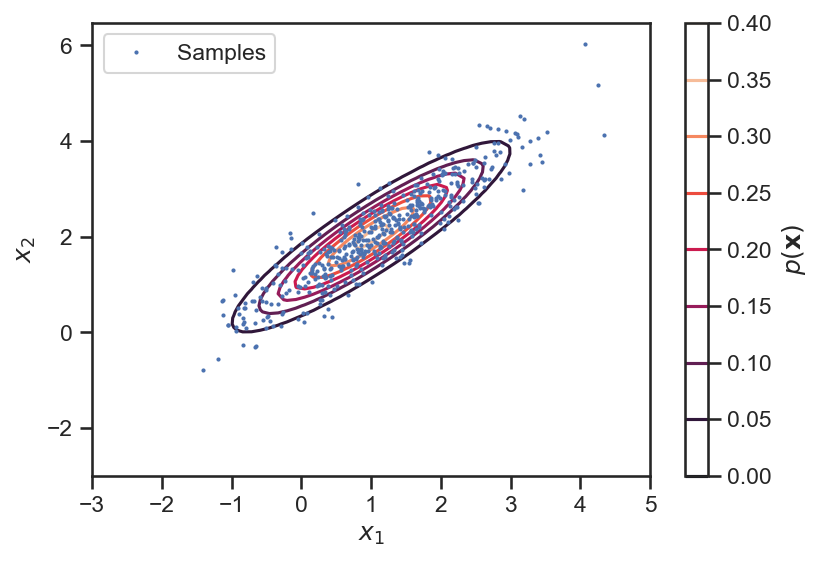

In [2]:
import scipy.stats as st

# The mean vector
mu = np.array([1.0, 2.0])
# The covariance matrix
Sigma = np.array(
    [
        [1.0, 0.9],
        [0.9, 1.0]
    ]
)
# The multivariate normal random vector
X = st.multivariate_normal(mean=mu, cov=Sigma)

# CONTOURS
fig, ax = plt.subplots(dpi=150)
x1 = np.linspace(-3, 5, 64)
x2 = np.linspace(-3, 5, 64)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.hstack(
    [
        X1.flatten()[:, None],
        X2.flatten()[:, None]
    ]
)
# PDF values
pdf_X = X.pdf(X_flat).reshape(X1.shape)
c = ax.contour(X1, X2, pdf_X)
plt.colorbar(c, label='$p(\mathbf{x})$')

# SAMPLES
num_samples = 500
x_samples = X.rvs(size=num_samples)
ax.plot(
    x_samples[:, 0],
    x_samples[:, 1],
    '.',
    markersize=2,
    label='Samples'
)
plt.legend(loc='best')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

## Questions
+ Rerun the steps above after moving $\boldsymbol{\mu}$ to $(0, 1)$. Observe how the contours of the PDF move.
+ Rerun the steps above for $\Sigma_{12} = \Sigma_{21} = 0.1$. Observe how the contours of the PDF change.
+ Rerun the steps above for $\Sigma_{12} = \Sigma_{21} = -0.9$. Observe how the contours of the PDF change.
+ Rerun the steps above for $\Sigma_{11} = 0.4$. Why does the code fail?

## The covariance matrix must be positive definite so that $p(\mathbf{x})$ has a well-defined, unique maximum

In the lecture we argued that the covariance matrix $\boldsymbol{\Sigma}$ must be positive definite so that the PDF of $\mathbf{X}$ has a unique maximum. Let's try to understand this step by step.
First, what does it mean for a matrix to be positive definite.
The mathematical definition stats that for any vector $\mathbf{v}\not=\mathbf{0}$, the quantity $\mathbf{v}^T\boldsymbol{\Sigma}\mathbf{v}$ is positive.

Let's just test this quantity for two different matrices.
One will be positive definite.
The other won't be.
I will draw random vectors $v$, evaluate the expression $\mathbf{v}^T\boldsymbol{\Sigma}\mathbf{v}$ and see what I get.

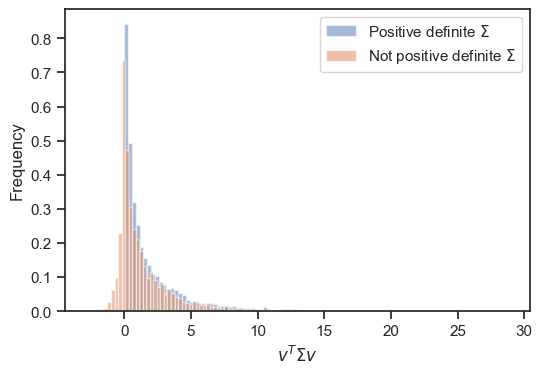

In [3]:
# A covariane matrix that we know works
Sigma_good = np.array(
    [
        [1.0, 0.9],
        [0.9, 1.0]
    ]
)

# A covariance matrix that we know does not work
Sigma_bad = np.array(
    [
        [0.4, 0.9],
        [0.9, 1.0]
    ]
)

# Take random vectors and compute at quantity
num_vectors = 5000
Q_good = np.ndarray((num_vectors,))
Q_bad = np.ndarray((num_vectors,))
for i in range(num_vectors):
    v = np.random.randn(2)
    Q_good[i] = v @ (Sigma_good @ v)
    Q_bad[i] = v @ (Sigma_bad @ v)

# Let's do the histograms of these quantities to see whether or not they are positive
fig, ax = plt.subplots()
ax.hist(
    Q_good,
    density=True,
    alpha=0.5,
    bins=100,
    label='Positive definite $\Sigma$'
)
ax.hist(
    Q_bad,
    density=True,
    alpha=0.5,
    bins=100,
    label='Not positive definite $\Sigma$'
)
ax.set_xlabel(r'$v^T\Sigma v$')
ax.set_ylabel('Frequency')
plt.legend(loc='best');

Observe that the non-positive definite matrix is giving us quite a few negative value.
Is there a way to check if a matrix is positive definite without doing this random test?
Yes, you just check if all the eigenvalues of the matrix are positive. Here is how:

In [4]:
print("Eigenvalues of Sigma_good", np.linalg.eigh(Sigma_good)[0])
print("Eigenvalues of Sigma_bad", np.linalg.eigh(Sigma_bad)[0])

Eigenvalues of Sigma_good [0.1 1.9]
Eigenvalues of Sigma_bad [-0.249  1.649]


... And you see that the second one has a negative eigenvlue.

Finally, let's visualize the contour of the probability densty and see with our own eyes that it does not have a unique minimum when the matrix $\boldsymbol{\Sigma}$ is not positive definite.

First, I define the PDF:

In [5]:
def pdf_mvn(x, mu, Sigma):
    """Compute the PDF of the multivariate Gaussian in a way that does not require
    Sigma to be positive definite, so that you can see what happens.
    
    Just keep in mind that this is not computationally efficient (or stable),
    but it is okay for this example.
    
    Arguments
    x     -- A 1D numpy array.
    mu    -- The mean vector.
    Sigma -- The covariance matrix.
    """
    N = Sigma.shape[0]
    return np.exp(
        -0.5 * N * np.log(2.0 * np.pi)
        - 0.5 * np.linalg.det(Sigma)
        - 0.5 * (x - mu) @ np.linalg.inv(Sigma) @ (x - mu)
    )

You can evaluate the array PDF at a point like this:

In [6]:
pdf_mvn(np.array([0.5, 0.6]), mu, Sigma)

0.011880260158671472

To do the contour, we have to evaluate the PDF at many points.
We can do this with a for loop.
But we can also [vectorize](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) our function:

In [7]:
vpdf_mvn = np.vectorize(
    pdf_mvn,
    excluded=[1, 2],
    signature="(n)->()"
)

In the above, `exclude` ensures that inputs 1 (`mu`) and 2 (`Sigma`) are not vectorized.
The `signature` tells numpy that `log_pdf_mv` function accepts a 1D array and returns a scalar.
Vectorization returns the function `vlog_pdf_mv` that acts on 2D arrays.
Each row corresponds to a different $\mathbf{X}$ sample.
Here is how:

In [8]:
vpdf_mvn(
    np.array(
        [
            [0.5, 0.6],
            [-0.1, 0.3],
            [1.5, -1.5]
        ]
    ),
    mu,
    Sigma
)

array([1.188e-02, 2.097e-02, 1.881e-19])

And now I can do the contour:

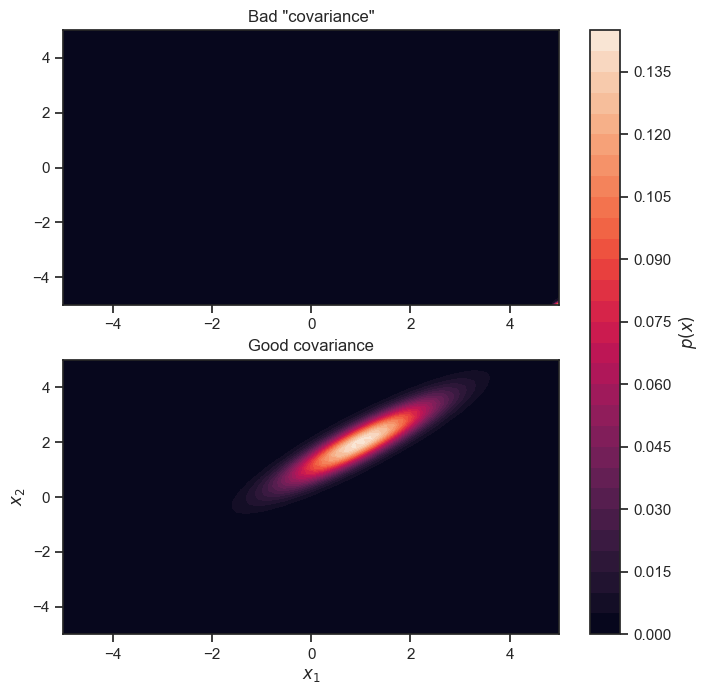

In [9]:
x1 = np.linspace(-5, 5, 64)
x2 = np.linspace(-5, 5, 64)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.hstack(
    [
        X1.flatten()[:, None],
        X2.flatten()[:, None]
    ]
)

Z_bad = vpdf_mvn(
    X_flat,
    mu,
    Sigma_bad
).reshape(X1.shape)

Z_good = vpdf_mvn(
    X_flat,
    mu,
    Sigma_good
).reshape(X1.shape)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8)
)
c = ax[0].contourf(
    X1,
    X2,
    Z_bad,
    levels=30
)
ax[0].set_title("Bad \"covariance\"")
c = ax[1].contourf(
    X1,
    X2,
    Z_good,
    levels=30
)
ax[1].set_title("Good covariance")
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
fig.colorbar(
    c,
    ax=ax.ravel().tolist(),
    label=r"$p(x)$"
);

Notice that $\boldsymbol{\mu}$ is not a maximum of $\log p(\mathbf{x})$ but a saddle point. 

## Questions

+ Rerun the code above for $\Sigma_{12} = \Sigma_{21} = -0.9$ (both for the "good" and the "bad" covariance).

## Sampling the multivariate normal with diagonal covariance using the standard normal

In the lecture we showed that if $\mathbf{Z}$ is an $N$-dimensional standard normal:

$$
\mathbf{Z} \sim N(0,\mathbf{I}),
$$

where $\mathbf{I}$ is the $N\times N$ unit matrix (all zeros except the diagonal which is all ones), then the random vector:

$$
\mathbf{X} = \boldsymbol{\mu} + \mathbf{A}\mathbf{Z},
$$

is a multivariate normal:

$$
\mathbf{X} \sim N\left(\boldsymbol{\mu}, \boldsymbol{\Sigma})\right),
$$

with

$$
\boldsymbol{\Sigma} = \mathbf{A}\mathbf{A}^T.
$$

Such a matrix $\mathbf{A}$ is non-unique and is is called a "square root" of $\boldsymbol{\Sigma}$.
The most commonnly used square root of $\boldsymbol{\Sigma}$, however, is the [Cholesky](https://www.youtube.com/watch?v=TprfUB3nI8Y) (and pronounced KOLESKI not TSOLESKI or SHOLESKI  -- at least by the people who taught me linear algebra!)
In the Cholesky decomposition $\mathbf{A}$ is a lower triangular matrix (everything above the diagonal is zero) and the diagonal contains only positive numbers.
Let's find the Cholesky decomposition of a positive definite $\boldsymbol{\Sigma}$:

In [10]:
# A covariane matrix that we know works
Sigma = np.array(
    [
        [1.0, 0.9],
        [0.9, 1.0]
    ]
)
A = np.linalg.cholesky(Sigma)
print("A =")
print(A)

A =
[[1.    0.   ]
 [0.9   0.436]]


In [11]:
# As a sanity check let's see if A * A.T gives us Sigma
print("A * A.T = ")
print(A @ A.T)
print("\nCompare to Sigma =")
print(Sigma)

A * A.T = 
[[1.  0.9]
 [0.9 1. ]]

Compare to Sigma =
[[1.  0.9]
 [0.9 1. ]]


Let's now verify that if we sample $\mathbf{Z}$ from $N(\mathbf{0},\mathbf{I})$ and evaluate $\mathbf{X} = \boldsymbol{\mu} + \mathbf{A}\mathbf{Z}$, then $\mathbf{X}$ will be distributed according to $N(\boldsymbol{\mu},\boldsymbol{\Sigma})$.

Let's write some code to take a single sample and then we will vectorize it.

In [12]:
def sample_mvn(mu, A):
    """Samples from a multivariate normal.
    
    Arguments
    mu -- The mean vector.
    A  -- The Cholesky decomposition of the covariance matrix.
    """
    z = np.random.randn(mu.shape[0])
    return mu + A @ z

Here is how it works:

In [13]:
for i in range(10):
    print(f"sample {i} = {sample_mvn(mu, A)}")

sample 0 = [-0.327  0.895]
sample 1 = [-0.74   0.123]
sample 2 = [1.072 1.71 ]
sample 3 = [0.413 1.605]
sample 4 = [0.751 2.68 ]
sample 5 = [1.805 2.984]
sample 6 = [2.185 3.459]
sample 7 = [-1.319 -0.118]
sample 8 = [0.349 1.187]
sample 9 = [1.063 2.241]


Let's make a function that will help us take many samples at once:

In [14]:
def sample_many_mvn(size, mu, A):
    """Sample many times from a multivariate Normal.
    
    Arguments
    size -- The number of samples.
    mu   -- The mean vector.
    A    -- The Cholesky decomposition of the covariance matrix.
    """
    return np.array(
        [
            sample_mvn(mu, A)
            for _ in range(size)
        ]
    )

And it works like this:

In [15]:
sample_many_mvn(10, mu, A)

array([[ 5.159e-03, -2.753e-02],
       [-1.570e+00, -7.716e-01],
       [ 1.785e+00,  3.209e+00],
       [ 2.523e+00,  3.679e+00],
       [ 1.864e+00,  3.121e+00],
       [ 1.509e+00,  2.315e+00],
       [ 1.149e-01,  1.071e+00],
       [ 4.603e+00,  5.988e+00],
       [ 1.356e-01,  1.839e+00],
       [ 1.751e+00,  1.985e+00]])

Let's plot some samples along with the contour of the PDF:

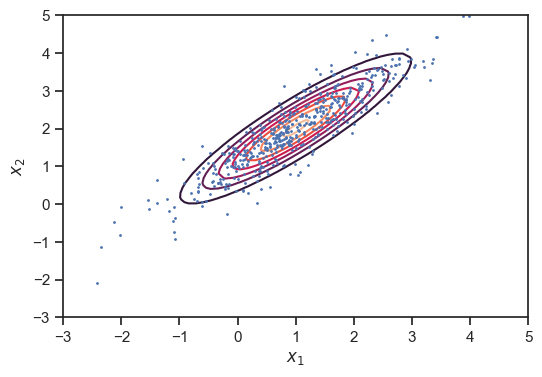

In [16]:
mu = np.array([1.0, 2.0])

Sigma = np.array(
    [
        [1.0, 0.9],
        [0.9, 1.0]
    ]
)

num_samples = 500
x_samples = sample_many_mvn(num_samples, mu, A)

x1 = np.linspace(-3, 5, 64)
x2 = np.linspace(-3, 5, 64)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.hstack(
    [
        X1.flatten()[:, None],
        X2.flatten()[:, None]
    ]
)
Z = vpdf_mvn(
        X_flat,
        mu,
        Sigma
).reshape(X1.shape)

fig, ax = plt.subplots()
c = ax.contour(X1, X2, Z)
ax.plot(
    x_samples[:, 0],
    x_samples[:, 1],
    '.',
    markersize=2
)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Now, in practice you do not have to use the code above to sample from a multivariate normal.
Everything is already implemeneted in `scipy.stats`.
Here is what you can do:

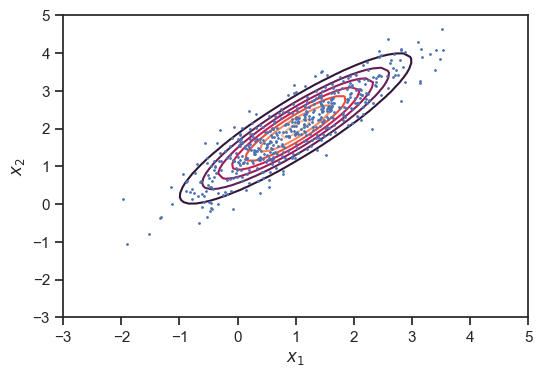

In [17]:
import scipy.stats as st

# A multivariate normal object
X = st.multivariate_normal(mu, Sigma)

# Evaluate the pdf
Z = X.pdf(X_flat).reshape(X1.shape)

# Take samples
x_samples = X.rvs(num_samples)

fig, ax = plt.subplots()
c = ax.contour(X1, X2, Z)
ax.plot(
    x_samples[:, 0],
    x_samples[:, 1],
    '.',
    markersize=2
)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

## Questions

+ Rerun the steps above after moving $\boldsymbol{\mu}$ to $(0, 1)$. Observe how the contours of the PDF move.
+ Rerun the steps above for $\Sigma_{12} = \Sigma_{21} = 0.1$. Observe how the contours of the PDF change.
+ Rerun the steps above for $\Sigma_{12} = \Sigma_{21} = -0.9$. Observe how the contours of the PDF change.